## Taller (Image Retrieval)
- Implementar un sistema de recuperción de texto-imagen (image retrieval)
- Usar imágenes de caltech 256 (tomar 20%-50%) imágenes aleatorias
- URL Dataset (https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1)

In [4]:
# Descargar el dataset desde la URL
!mkdir -p data/caltech
!curl -L "https://data.caltech.edu/records/nyy15-4j048/files/256_ObjectCategories.tar?download=1" -o data/caltech/256_ObjectCategories.tar

# Extraer el archivo descargado
!tar -xvf data/caltech/256_ObjectCategories.tar -C data/caltech --strip-components=1

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   485  100   485    0     0   1119      0 --:--:-- --:--:-- --:--:--  1120
  3 1128M    3 39.8M    0     0  73986      0  4:26:29  0:09:24  4:17:05     0   0  0:33:27  0:01:10  0:32:17     0  0   374k      0  0:51:28  0:01:48  0:49:40     0 0   357k      0  0:53:50  0:01:53  0:51:57     0M    0     0   323k      0  0:59:31  0:02:06  0:57:25     002:12  1:00:10     0:41  1:13:36     0    0  1:20:05  0:02:49  1:17:16     0    0  1:21:02  0:02:51  1:18:11     0 0     0   229k      0  1:23:52  0:02:57  1:20:55     00   184k      0  1:44:16  0:03:40  1:40:36     053:45  0:04:00  1:49:45     0:51:35     004:07  1:52:57     0     0  2:12:15  0:04:39  2:07:36     024k      0  2:35:00  0:05:28  2:29:32     0:05:44  2:36:51     0k      0  2:44:29  0:05:48  2:38:41     0    0     0   112k      0  2:51:07  0:06:02  2:45:05     0      0  2

In [ ]:
import random
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# --- Selección dinámica del dispositivo ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando GPU NVIDIA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando GPU Apple Silicon (MPS)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando GPU Apple Silicon (MPS)


In [8]:
# Se hace uso del modelo CLIP de OpenAI
!pip install git+https://github.com/openai/CLIP.gitx

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/b8/cfx8ngsn4zb5r8yj4vlfkcwr0000gn/T/pip-req-build-6dj09uww
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/b8/cfx8ngsn4zb5r8yj4vlfkcwr0000gn/T/pip-req-build-6dj09uww
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369549 sha256=ee8419e53c145d041c3d6e387d2ffd723e8879e27726d6b26290c137566eb484
  Stored in directory: /private/var/folders/b8/cfx8ngsn4zb5r8yj4vlfkcwr0000gn/T/pip-ephem-wheel-cache-jsbrj9cc/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [9]:
import clip
model, preprocess = clip.load("ViT-B/32", device=device)


100%|███████████████████████████████████████| 338M/338M [01:00<00:00, 5.85MiB/s]


In [11]:
# Ruta donde se extrajo el dataset
data_dir = "./data/caltech"

# Cargar el dataset con ImageFolder: se asume que la estructura de directorios está organizada por categorías
dataset = ImageFolder(root=data_dir, transform=preprocess)

In [12]:
# Seleccionar un subconjunto aleatorio (ejemplo: 30% de las imágenes)
subset_percentage = 0.3
subset_size = int(len(dataset) * subset_percentage)
indices = random.sample(range(len(dataset)), subset_size)
subset = Subset(dataset, indices)

In [13]:
# Precomputar las incrustaciones (embeddings) de las imágenes
all_images = []  # [(imagen, label), ...]
all_embeddings = []  # embeddings de cada imagen

model.eval()
with torch.no_grad():
    for i in range(len(subset)):
        image, label = subset[i]
        # La imagen ya está preprocesada; agregar dimensión de batch
        image_batch = image.unsqueeze(0).to(device)
        embedding = model.encode_image(image_batch)
        # Normalizar la incrustación
        embedding = embedding / embedding.norm(dim=-1, keepdim=True)
        all_embeddings.append(embedding.cpu())
        all_images.append((image, subset.dataset.classes[label]))
all_embeddings = torch.cat(all_embeddings, dim=0)


In [14]:
def retrieve_images(text_query, top_k=5):
    """
    Dado un query en texto, recupera las top_k imágenes más similares.
    """
    model.eval()
    with torch.no_grad():
        # Tokenizar y codificar el query de texto
        text_tokens = clip.tokenize([text_query]).to(device)
        text_embedding = model.encode_text(text_tokens)
        text_embedding = text_embedding / text_embedding.norm(dim=-1, keepdim=True)
        # Calcular similitud coseno entre la incrustación de texto y las de imágenes
        similarities = (all_embeddings @ text_embedding.cpu().T).squeeze(1).numpy()
        # Seleccionar los índices con mayor similitud
        top_indices = similarities.argsort()[::-1][:top_k]
    return top_indices, similarities[top_indices]


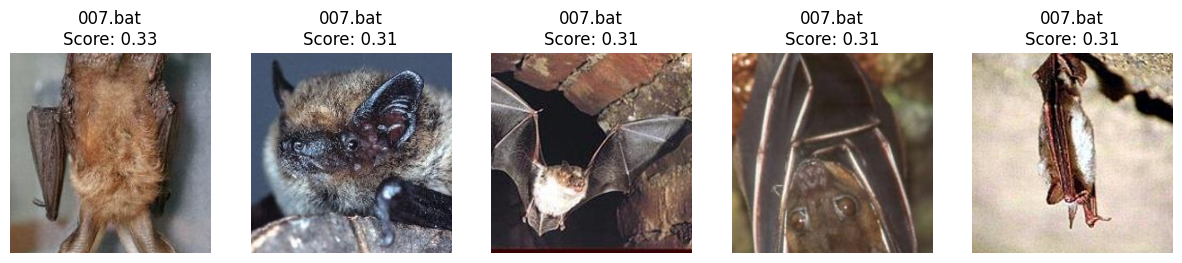

In [41]:
# Ejemplo de uso:
query = "bat"
top_indices, scores = retrieve_images(query, top_k=5)

# Mostrar las imágenes recuperadas junto con su puntuación
plt.figure(figsize=(15,5))
for idx, (img_idx, score) in enumerate(zip(top_indices, scores)):
    img_tensor, label = all_images[img_idx]
    # Convertir el tensor a imagen para visualizar (invierte la normalización de CLIP)
    img = img_tensor.cpu().permute(1,2,0).numpy()
    mean = np.array([0.48145466, 0.4578275, 0.40821073])
    std = np.array([0.26862954, 0.26130258, 0.27577711])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.subplot(1, 5, idx+1)
    plt.imshow(img)
    plt.title(f"{label}\nScore: {score:.2f}")
    plt.axis("off")
plt.show()